In [2]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'text.fontsize': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)


# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(512000,)


<IPython.core.display.Javascript object>


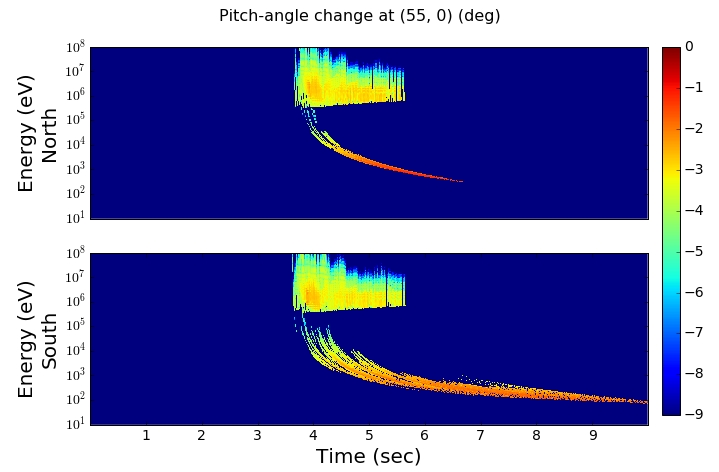

Max N (deg):  8.54330096104
Max S (deg):  2.41866939916
30117


In [218]:
out_dir   = '../outputs/wipp_test/'
out_lat   = 55
out_lon   = 0
out_freq  = 200

# N_filename = os.path.join(out_dir, "pN_%d_%d_%d.dat"%(out_lat, out_lon, out_freq))
# S_filename = os.path.join(out_dir, "pS_%d_%d_%d.dat"%(out_lat, out_lon, out_freq))
NUM_E = 512;
NUM_TIMES = 1000;
T_MAX = 10
T_STEP = np.floor(T_MAX/NUM_TIMES)
E_MIN = 1e1
E_MAX = 1e8
NUM_E = 512
E_EXP_TOP = np.log10(E_MAX)
E_EXP_BOT = np.log10(E_MIN)
DE_EXP = ((E_EXP_TOP - E_EXP_BOT)/(NUM_E))

tvec = np.linspace(T_STEP,T_MAX,NUM_TIMES)
E_tot_arr = pow(10, (E_EXP_BOT + DE_EXP*np.arange(NUM_E)) ) # energy in eV


clims =[-9, 0]

pN, pS = sum_p_files(out_dir, out_lat, out_lon)
# pN = np.loadtxt(N_filename)
# pS = np.loadtxt(S_filename)

print np.shape(pS)


pN = pN.reshape(NUM_E, NUM_TIMES, order='c')
pS = pS.reshape(NUM_E, NUM_TIMES, order='c')

pN_P = np.log10(np.sqrt(pN))
np.clip(pN_P,clims[0],clims[1],out=pN_P)

pS_P = np.log10(np.sqrt(pS))
np.clip(pS_P,clims[0],clims[1],out=pS_P)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

p1 = ax1.imshow(pN_P,origin='lower',aspect='auto', interpolation='none')
p1.set_clim(clims)
p2 = ax2.imshow(pS_P,origin='lower',aspect='auto', interpolation='none')
p2.set_clim(clims)
 
cax = fig.add_axes([0.92, 0.12, 0.025, 0.78])
fig.colorbar(p1,cax=cax)
# Label axes

tlabels = np.arange(1,np.floor(T_MAX))
tinds =  [np.argmax(tt <= tvec) for tt in tlabels]
ax2.set_xticks(tinds)
tlabel_strings = ['%d'%k for k in tlabels]
ax2.set_xticklabels(tlabel_strings)


ax1.get_xaxis().set_visible(False)
#     ax2.set_xticks(np.floor(np.linspace(0,sc.NUM_STEPS-1,sc.T_MAX + 1)))
#     ax2.set_xticklabels(np.floor(tvec[ax2.get_xticks().astype(int)]))

# Label each power of 10
logvals = np.arange(np.log10(E_MIN), np.log10(E_MAX)+1)
einds =  [np.argmax(lv <= np.log10(E_tot_arr)) for lv in logvals]
einds[-1] = NUM_E - 1 

ylabel_strings = ['$10^%d$'%k for k in logvals]
ax1.set_yticks(einds)
ax1.set_yticklabels(ylabel_strings)
ax1.set_ylabel('Energy (eV)\nNorth')
ax2.set_yticks(einds)
ax2.set_yticklabels(ylabel_strings)
ax2.set_ylabel('Energy (eV)\nSouth')
ax2.set_xlabel('Time (sec)')
fig.suptitle('Pitch-angle change at (%d, %d) (deg)'%(out_lat, out_lon))
print "Max N (deg): ", np.max((180./np.pi)*np.sqrt(pN))
print "Max S (deg): ", np.max((180./np.pi)*np.sqrt(pS))

# print np.max(pS_P)
# print np.min(pS_P)
# print np.max(pS)
print sum(sum((pN!=0)))

In [113]:
f1 = 200; f2 = 30000;
flogs = np.linspace(np.log10(f1), np.log10(f2), 32)
flins = np.round(pow(10, flogs)/10.)*10
print flins

[   200.    240.    280.    320.    380.    450.    530.    620.    730.
    860.   1010.   1180.   1390.   1640.   1920.   2260.   2660.   3120.
   3670.   4310.   5070.   5960.   7000.   8230.   9680.  11370.  13370.
  15720.  18470.  21710.  25520.  30000.]


In [212]:
def sum_p_files(out_dir, lat, lon):
    d = os.listdir(out_dir)
    pNfiles = [x for x in d if x.startswith('pN_%d_%d'%(lat, lon))]
    pSfiles = [x for x in d if x.startswith('pS_%d_%d'%(lat, lon))]
        
    pN = None
    for x in pNfiles:

#         tmp = np.loadtxt(os.path.join(out_dir, x))
        tmp = np.fromfile(os.path.join(out_dir, x),dtype=np.dtype('<f8'))
        if pN is None:
            pN = tmp
        else:
            pN += tmp

#         print "loading %s"%(x)
#         print np.sum(np.sum(pN))


    pS = None
    for x in pSfiles:
#         tmp = np.loadtxt(os.path.join(out_dir, x))
        tmp = np.fromfile(os.path.join(out_dir, x),dtype=np.dtype('<f8'))
        if pS is None:
            pS = tmp
        else:
            pS += tmp
        
#         print "loading %s"%(x)
#         print np.sum(np.sum(pS))
    return pN, pS



# out_dir   = '../outputs/test_WIPP_outs/'
# out_lat   = 50
# out_lon   = 0
# out_freq  = 450
# NUM_E = 512;
# NUM_TIMES = 1000;

# sum_p_files('../outputs/test_WIPP_outs/', out_lat, out_lon)



<IPython.core.display.Javascript object>


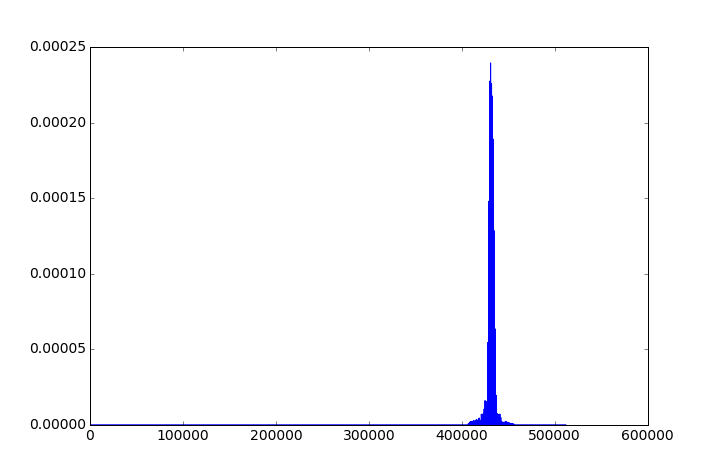

In [186]:
dd = np.fromfile('/shared/users/asousa/WIPP/3dWIPP/outputs/wipp_test/pN_40_0_200.dat', dtype = np.dtype('<f8'))
